# Laboratory values vs outcome

Get the first laboratory measurements for patients admitted to the ICU. Plot the distribution of measurements for survival and non-survival groups.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
from scipy.stats import ks_2samp
%matplotlib inline
plt.style.use('ggplot') 

In [2]:
# create a database connection
sqluser = 'mimicuser'
sqlpassword = 'mimicpass'
dbname = 'mimic'
schema_name = 'mimiciii'

## Lab ranges

'Normal' ranges for lab values:

Lab Value	|  Lower limit	|  Upper Limit	|  Units
--- | --- | --- | ---
Bicarbonate	| 22	| 32	| mEq/L
BUN	| 6	| 20 | mEq/L
Calcium	| 8.4	| 10.3	| mg/dL
Chloride	| 96	| 108	| mEq/L
Creatinine	| 0.4	| 1.1	| mEq/L
Hemoglobin	| 11.2	 | 15.7	| g/dL
Lactate	| 0.5	| 2	| mmol/L
Magnesium	| 1.6	| 2.6	| mg/dL
Phosphate	| 2.7	| 4.5	| mg/dL
Platelet count	| 150	| 400	| K/uL
Potassium	| 3.3	| 5.1	| mEq/L
Sodium	| 133	| 145	| mEq/L


In [3]:
# Create dictionary of ranges
# Keys should match the lab names in the query below
# Are these values correct given the units? Need to check.

lab_ranges = {'BICARBONATE': [22,32],
              'BUN': [6,20],
              'CALCIUM': [8.4,10.3],
              'CHLORIDE': [96,108],
              'CREATININE': [0.4,1.1],
              'HEMOGLOBIN': [11.2,15.7],
              'LACTATE': [0.5,2.0],
              'MAGNESIUM': [1.6,2.6],
              'PHOSPHATE': [2.7,4.5],
              'PLATELET': [150,400],
              'POTASSIUM': [3.3,5.1],
              'SODIUM': [133,145]
             }


## Get first laboratory measurement on ICU admission

In [4]:
# Connect to local postgres version of mimic
con = psycopg2.connect(dbname=dbname, host='localhost', user=sqluser, password=sqlpassword)
cur = con.cursor()
cur.execute('SET search_path to {}'.format(schema_name))

# Modify first day labs code: 
# https://github.com/MIT-LCP/mimic-code/tree/master/etc/firstday
query = \
"""
WITH pvt AS (
  SELECT ie.subject_id, ie.hadm_id, ie.outtime, ie.icustay_id, le.charttime, ad.deathtime
  , CASE when ad.deathtime between ie.intime and ie.outtime THEN 1 ELSE 0 END AS mort_icu
  , CASE when ad.deathtime between ad.admittime and ad.dischtime THEN 1 ELSE 0 END AS mort_hosp
  -- here we assign labels to ITEMIDs
  -- this also fuses together multiple ITEMIDs containing the same data
  , CASE
        when le.itemid = 50868 then 'ANION GAP'
        when le.itemid = 50862 then 'ALBUMIN'
        when le.itemid = 50882 then 'BICARBONATE'
        when le.itemid = 50885 then 'BILIRUBIN'
        when le.itemid = 50912 then 'CREATININE'
        when le.itemid = 50806 then 'CHLORIDE'
        when le.itemid = 50902 then 'CHLORIDE'
        when itemid = 50809 then 'GLUCOSE'
        when itemid = 50931 then 'GLUCOSE'
        when itemid = 50810 then 'HEMATOCRIT'
        when itemid = 51221 then 'HEMATOCRIT'
        when itemid = 50811 then 'HEMOGLOBIN'
        when itemid = 51222 then 'HEMOGLOBIN'
        when itemid = 50813 then 'LACTATE'
        when itemid = 50960 then 'MAGNESIUM'
        when itemid = 50970 then 'PHOSPHATE'
        when itemid = 51265 then 'PLATELET'
        when itemid = 50822 then 'POTASSIUM'
        when itemid = 50971 then 'POTASSIUM'
        when itemid = 51275 then 'PTT'
        when itemid = 51237 then 'INR'
        when itemid = 51274 then 'PT'
        when itemid = 50824 then 'SODIUM'
        when itemid = 50983 then 'SODIUM'
        when itemid = 51006 then 'BUN'
        when itemid = 51300 then 'WBC'
        when itemid = 51301 then 'WBC'
      ELSE null
      END AS label
  , -- add in some sanity checks on the values
    -- the where clause below requires all valuenum to be > 0, 
    -- so these are only upper limit checks
    CASE
      when le.itemid = 50862 and le.valuenum >    10 then null -- g/dL 'ALBUMIN'
      when le.itemid = 50868 and le.valuenum > 10000 then null -- mEq/L 'ANION GAP'
      when le.itemid = 50882 and le.valuenum > 10000 then null -- mEq/L 'BICARBONATE'
      when le.itemid = 50885 and le.valuenum >   150 then null -- mg/dL 'BILIRUBIN'
      when le.itemid = 50806 and le.valuenum > 10000 then null -- mEq/L 'CHLORIDE'
      when le.itemid = 50902 and le.valuenum > 10000 then null -- mEq/L 'CHLORIDE'
      when le.itemid = 50912 and le.valuenum >   150 then null -- mg/dL 'CREATININE'
      when le.itemid = 50809 and le.valuenum > 10000 then null -- mg/dL 'GLUCOSE'
      when le.itemid = 50931 and le.valuenum > 10000 then null -- mg/dL 'GLUCOSE'
      when le.itemid = 50810 and le.valuenum >   100 then null -- % 'HEMATOCRIT'
      when le.itemid = 51221 and le.valuenum >   100 then null -- % 'HEMATOCRIT'
      when le.itemid = 50811 and le.valuenum >    50 then null -- g/dL 'HEMOGLOBIN'
      when le.itemid = 51222 and le.valuenum >    50 then null -- g/dL 'HEMOGLOBIN'
      when le.itemid = 50813 and le.valuenum >    50 then null -- mmol/L 'LACTATE'
      when le.itemid = 50960 and le.valuenum >    60 then null -- mmol/L 'MAGNESIUM'
      when le.itemid = 50970 and le.valuenum >    60 then null -- mg/dL 'PHOSPHATE'
      when le.itemid = 51265 and le.valuenum > 10000 then null -- K/uL 'PLATELET'
      when le.itemid = 50822 and le.valuenum >    30 then null -- mEq/L 'POTASSIUM'
      when le.itemid = 50971 and le.valuenum >    30 then null -- mEq/L 'POTASSIUM'
      when le.itemid = 51275 and le.valuenum >   150 then null -- sec 'PTT'
      when le.itemid = 51237 and le.valuenum >    50 then null -- 'INR'
      when le.itemid = 51274 and le.valuenum >   150 then null -- sec 'PT'
      when le.itemid = 50824 and le.valuenum >   200 then null -- mEq/L == mmol/L 'SODIUM'
      when le.itemid = 50983 and le.valuenum >   200 then null -- mEq/L == mmol/L 'SODIUM'
      when le.itemid = 51006 and le.valuenum >   300 then null -- 'BUN'
      when le.itemid = 51300 and le.valuenum >  1000 then null -- 'WBC'
      when le.itemid = 51301 and le.valuenum >  1000 then null -- 'WBC'
    ELSE le.valuenum
    END AS valuenum
  FROM icustays ie

  LEFT JOIN labevents le
    ON le.subject_id = ie.subject_id 
    AND le.hadm_id = ie.hadm_id
    AND le.charttime between (ie.intime - interval '6' hour) 
    AND (ie.intime + interval '1' day)
    AND le.itemid IN
    (
      -- comment is: LABEL | CATEGORY | FLUID | NUMBER OF ROWS IN LABEVENTS
      50868, -- ANION GAP | CHEMISTRY | BLOOD | 769895
      50862, -- ALBUMIN | CHEMISTRY | BLOOD | 146697
      50882, -- BICARBONATE | CHEMISTRY | BLOOD | 780733
      50885, -- BILIRUBIN, TOTAL | CHEMISTRY | BLOOD | 238277
      50912, -- CREATININE | CHEMISTRY | BLOOD | 797476
      50902, -- CHLORIDE | CHEMISTRY | BLOOD | 795568
      50806, -- CHLORIDE, WHOLE BLOOD | BLOOD GAS | BLOOD | 48187
      50931, -- GLUCOSE | CHEMISTRY | BLOOD | 748981
      50809, -- GLUCOSE | BLOOD GAS | BLOOD | 196734
      51221, -- HEMATOCRIT | HEMATOLOGY | BLOOD | 881846
      50810, -- HEMATOCRIT, CALCULATED | BLOOD GAS | BLOOD | 89715
      51222, -- HEMOGLOBIN | HEMATOLOGY | BLOOD | 752523
      50811, -- HEMOGLOBIN | BLOOD GAS | BLOOD | 89712
      50813, -- LACTATE | BLOOD GAS | BLOOD | 187124
      50960, -- MAGNESIUM | CHEMISTRY | BLOOD | 664191
      50970, -- PHOSPHATE | CHEMISTRY | BLOOD | 590524
      51265, -- PLATELET COUNT | HEMATOLOGY | BLOOD | 778444
      50971, -- POTASSIUM | CHEMISTRY | BLOOD | 845825
      50822, -- POTASSIUM, WHOLE BLOOD | BLOOD GAS | BLOOD | 192946
      51275, -- PTT | HEMATOLOGY | BLOOD | 474937
      51237, -- INR(PT) | HEMATOLOGY | BLOOD | 471183
      51274, -- PT | HEMATOLOGY | BLOOD | 469090
      50983, -- SODIUM | CHEMISTRY | BLOOD | 808489
      50824, -- SODIUM, WHOLE BLOOD | BLOOD GAS | BLOOD | 71503
      51006, -- UREA NITROGEN | CHEMISTRY | BLOOD | 791925
      51301, -- WHITE BLOOD CELLS | HEMATOLOGY | BLOOD | 753301
      51300  -- WBC COUNT | HEMATOLOGY | BLOOD | 2371
    )
    AND le.valuenum IS NOT null 
    AND le.valuenum > 0 -- lab values cannot be 0 and cannot be negative
    
    LEFT JOIN admissions ad
    ON ie.subject_id = ad.subject_id
    AND ie.hadm_id = ad.hadm_id
    
    -- WHERE ie.subject_id < 10000
    
),
ranked AS (
SELECT pvt.*, DENSE_RANK() OVER (PARTITION BY 
    pvt.subject_id, pvt.hadm_id,pvt.icustay_id,pvt.label ORDER BY pvt.charttime) as drank
FROM pvt
)
SELECT r.subject_id, r.hadm_id, r.icustay_id, r.mort_icu, r.mort_hosp
  , max(case when label = 'ANION GAP' then valuenum else null end) as ANIONGAP_1st
  , max(case when label = 'ALBUMIN' then valuenum else null end) as ALBUMIN_1st
  , max(case when label = 'BICARBONATE' then valuenum else null end) as BICARBONATE_1st
  , max(case when label = 'BILIRUBIN' then valuenum else null end) as BILIRUBIN_1st
  , max(case when label = 'CREATININE' then valuenum else null end) as CREATININE_1st
  , max(case when label = 'CHLORIDE' then valuenum else null end) as CHLORIDE_1st
  , max(case when label = 'GLUCOSE' then valuenum else null end) as GLUCOSE_1st
  , max(case when label = 'HEMATOCRIT' then valuenum else null end) as HEMATOCRIT_1st
  , max(case when label = 'HEMOGLOBIN' then valuenum else null end) as HEMOGLOBIN_1st
  , max(case when label = 'LACTATE' then valuenum else null end) as LACTATE_1st
  , max(case when label = 'MAGNESIUM' then valuenum else null end) as MAGNESIUM_1st
  , max(case when label = 'PHOSPHATE' then valuenum else null end) as PHOSPHATE_1st
  , max(case when label = 'PLATELET' then valuenum else null end) as PLATELET_1st
  , max(case when label = 'POTASSIUM' then valuenum else null end) as POTASSIUM_1st
  , max(case when label = 'PTT' then valuenum else null end) as PTT_1st
  , max(case when label = 'INR' then valuenum else null end) as INR_1st
  , max(case when label = 'PT' then valuenum else null end) as PT_1st
  , max(case when label = 'SODIUM' then valuenum else null end) as SODIUM_1st
  , max(case when label = 'BUN' then valuenum else null end) as BUN_1st
  , max(case when label = 'WBC' then valuenum else null end) as WBC_1st

FROM ranked r
WHERE r.drank = 1
GROUP BY r.subject_id, r.hadm_id, r.icustay_id, r.mort_icu, r.mort_hosp, r.drank
ORDER BY r.subject_id, r.hadm_id, r.icustay_id, r.mort_icu, r.mort_hosp, r.drank;
"""

data = pd.read_sql_query(query,con)

In [5]:
data.head()

,subject_id,hadm_id,icustay_id,mort_icu,mort_hosp,aniongap_1st,albumin_1st,bicarbonate_1st,bilirubin_1st,creatinine_1st,...,magnesium_1st,phosphate_1st,platelet_1st,potassium_1st,ptt_1st,inr_1st,pt_1st,sodium_1st,bun_1st,wbc_1st
0,2,163353,243653,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,0.1
1,3,145834,211552,0,0,17.0,1.8,25.0,0.8,3.2,...,2.4,4.8,282.0,5.4,30.7,1.3,13.5,136.0,53.0,12.7
2,4,185777,294638,0,0,15.0,2.8,21.0,1.9,0.5,...,1.9,3.1,201.0,3.3,33.2,1.1,12.8,141.0,10.0,9.7
3,5,178980,214757,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,309.0,NaN,NaN,NaN,NaN,NaN,NaN,13.9
4,6,107064,228232,0,0,23.0,3.0,15.0,0.2,11.7,...,2.0,8.5,315.0,5.4,139.0,1.4,14.6,138.0,62.0,10.6


## First laboratory measurement on ICU admission vs ICU mortality

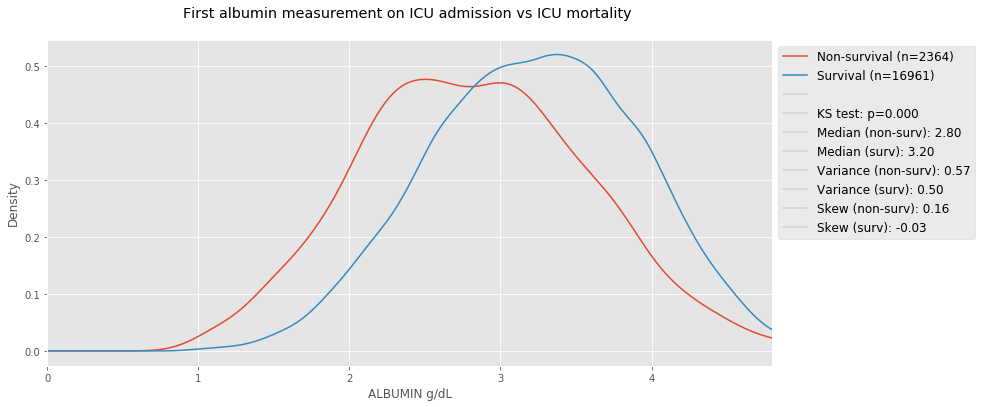

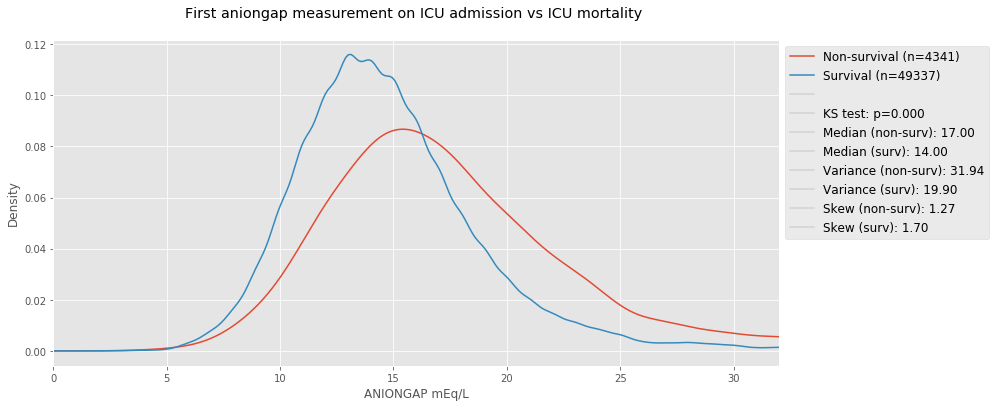

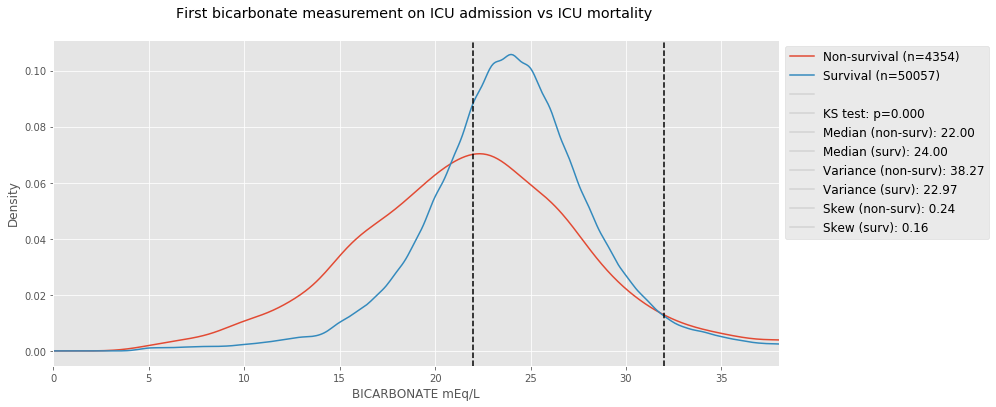

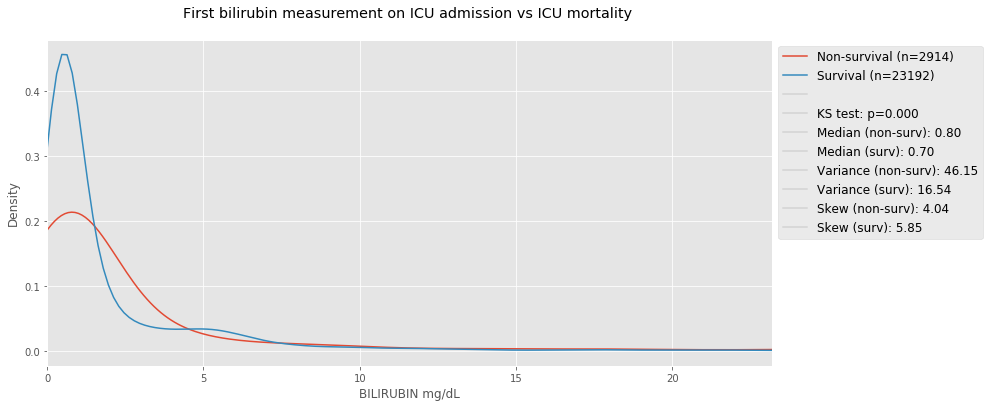

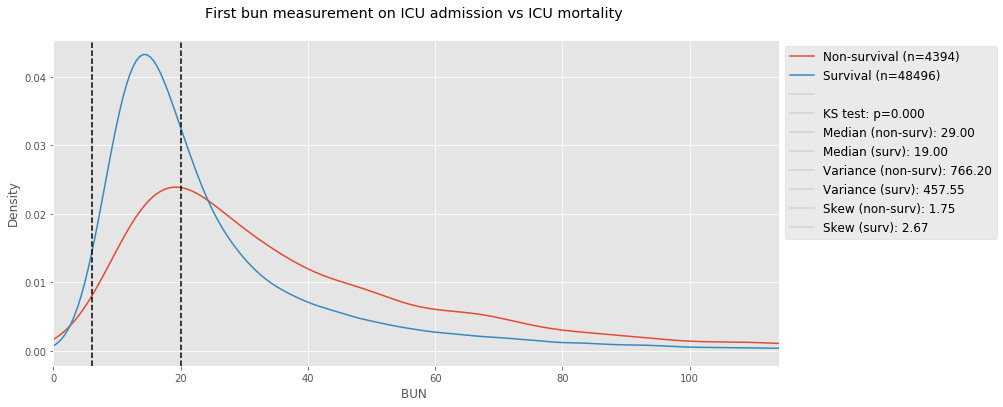

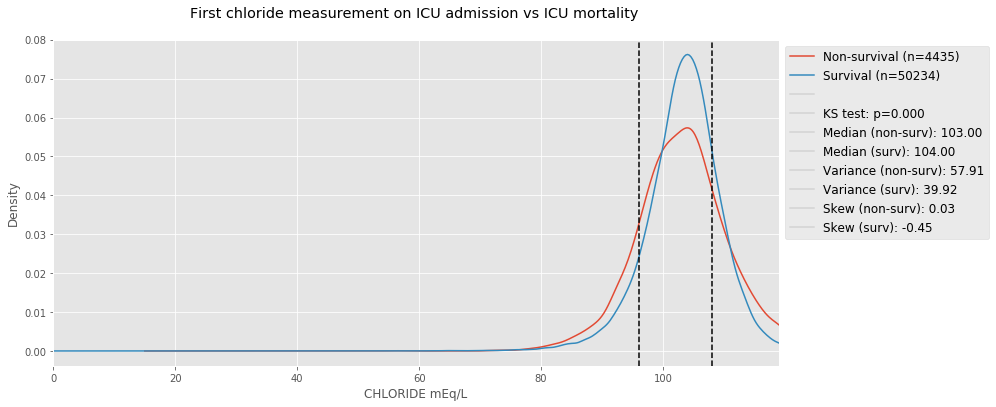

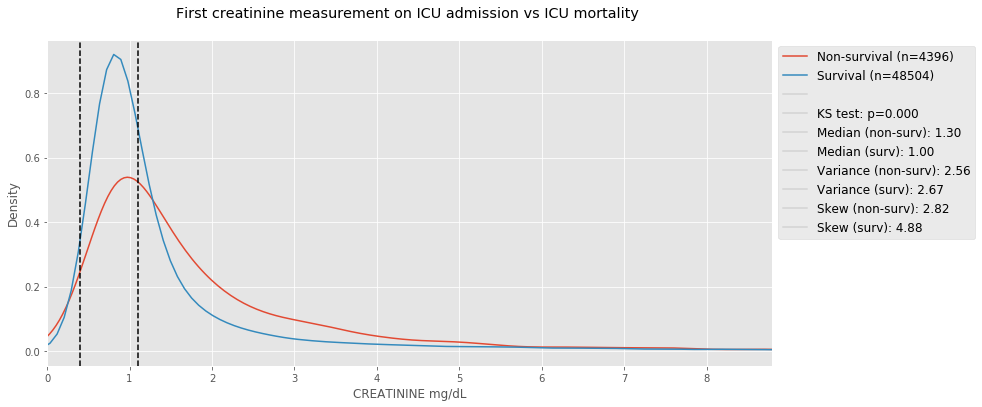

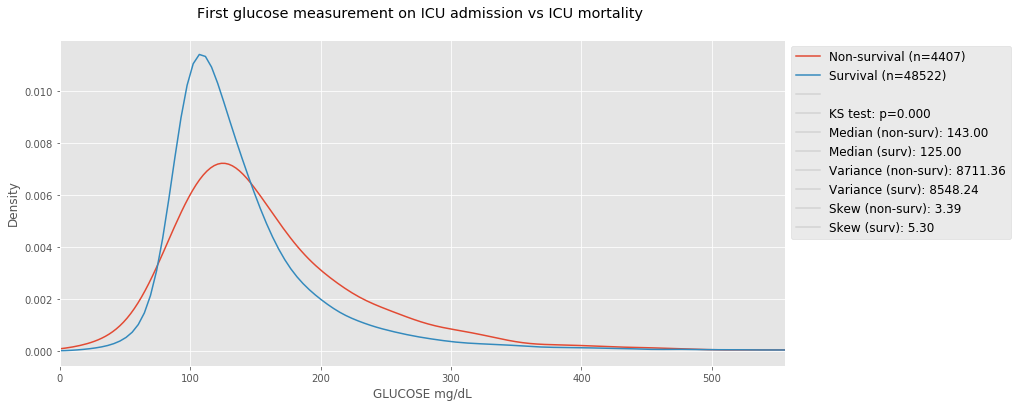

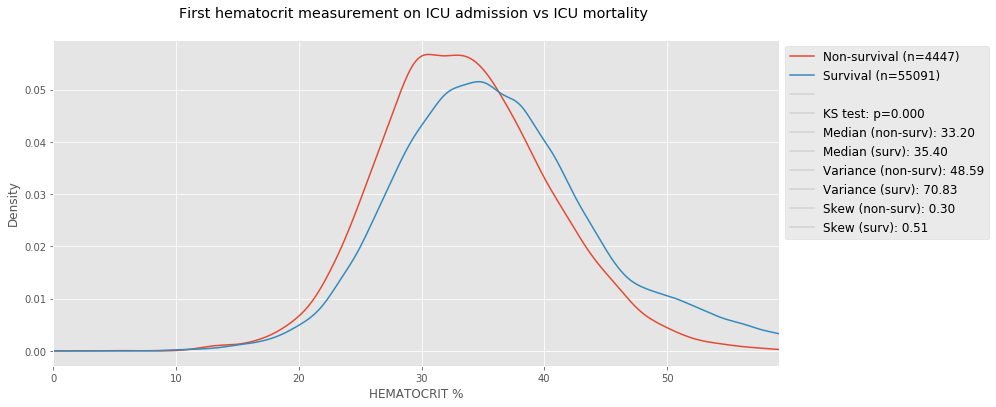

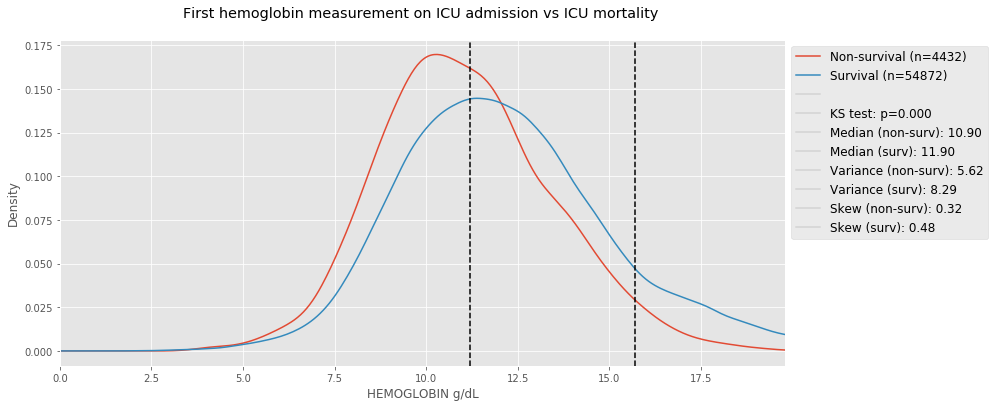

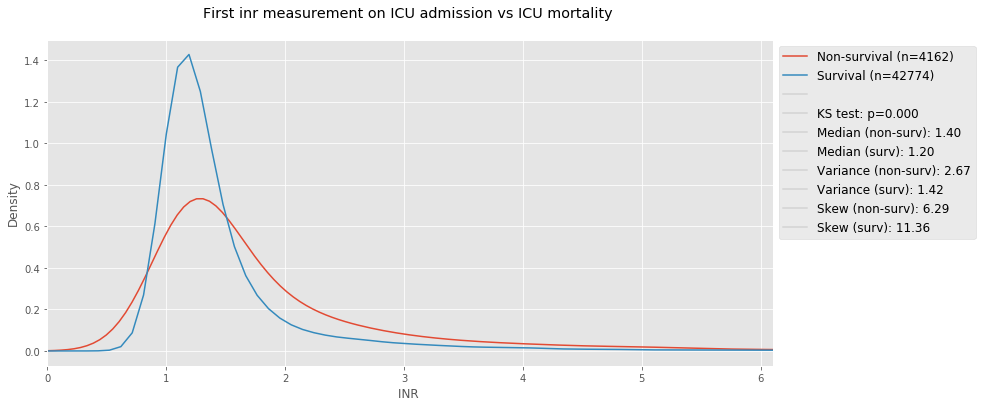

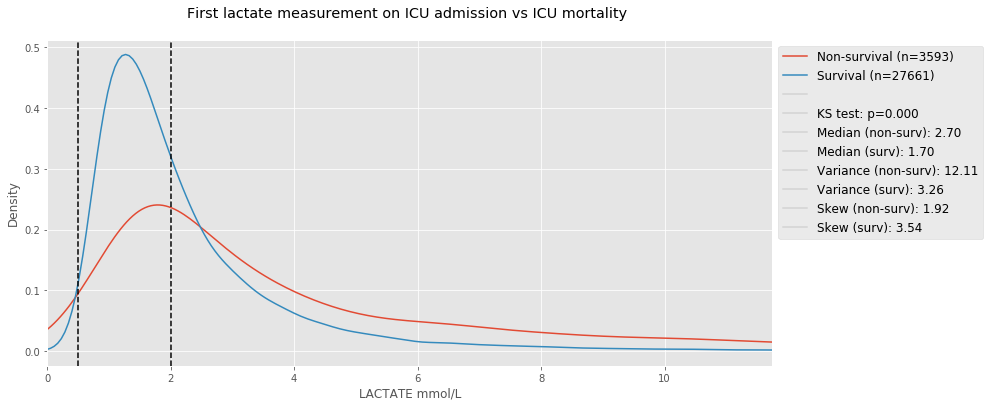

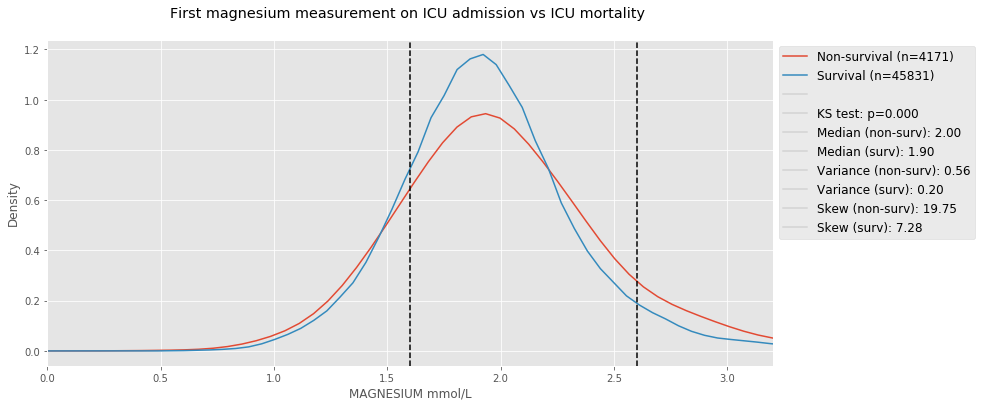

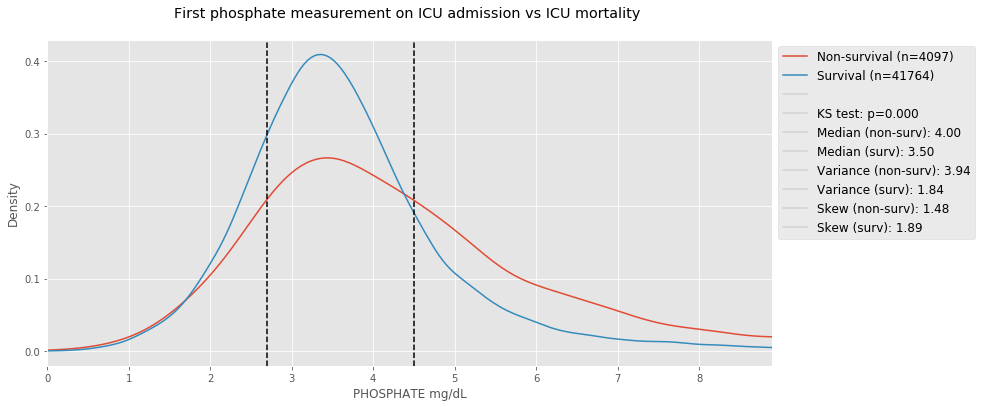

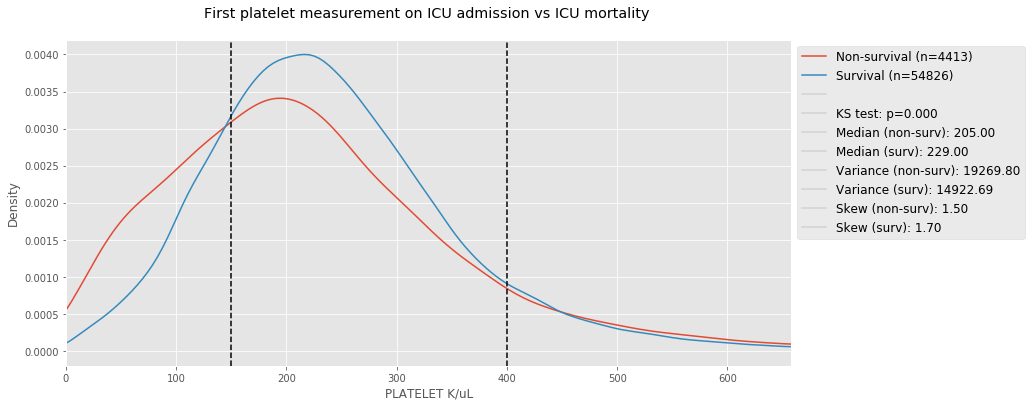

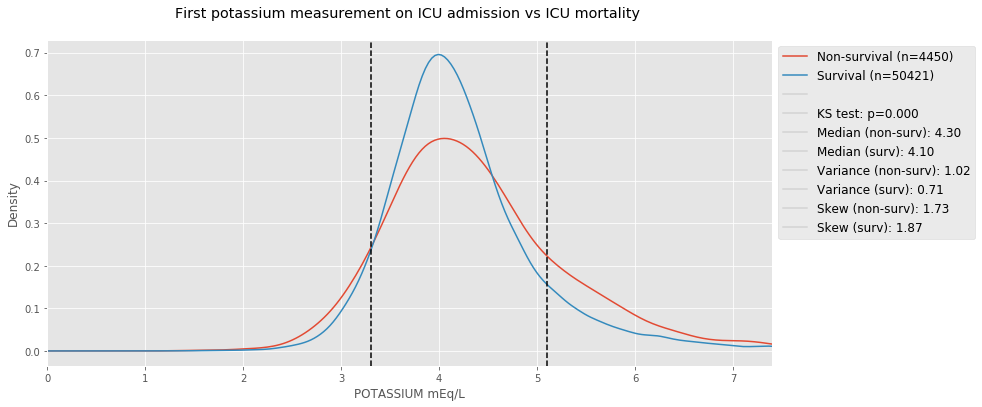

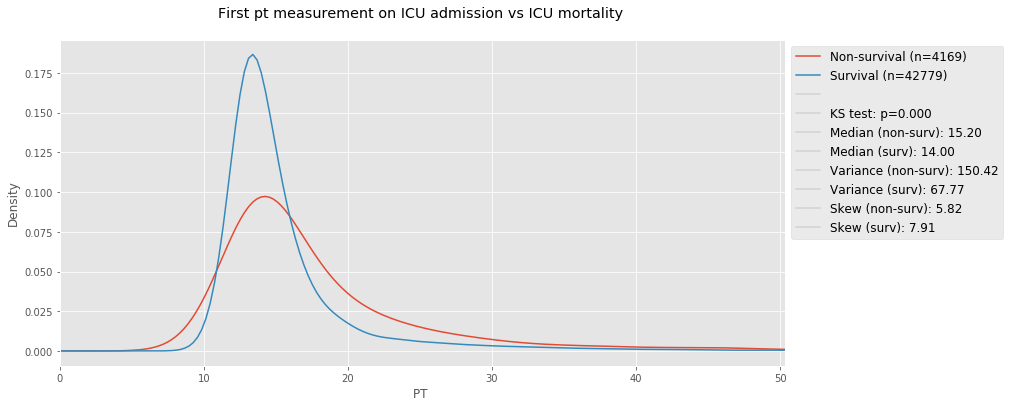

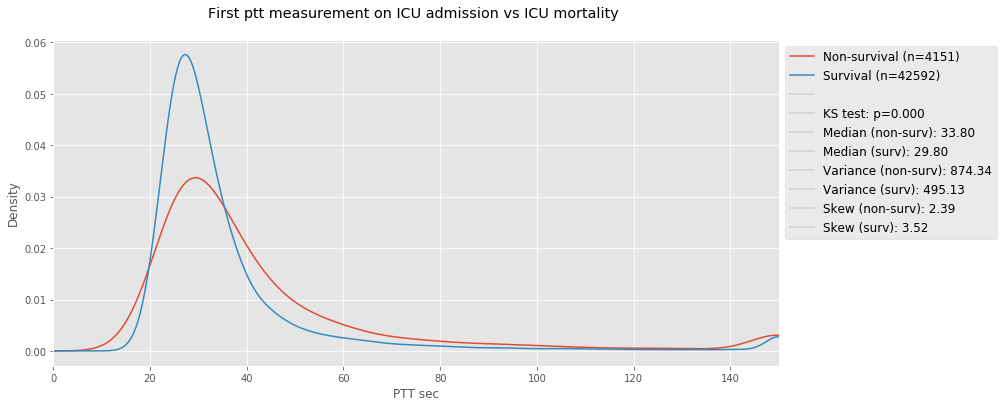

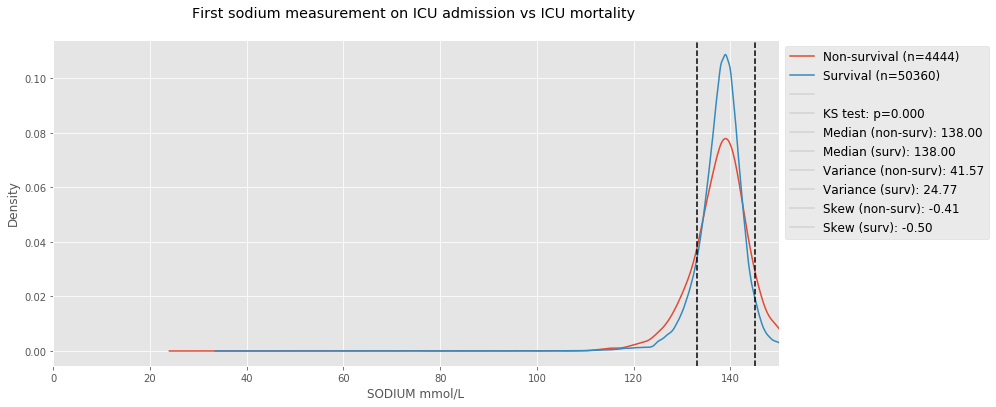

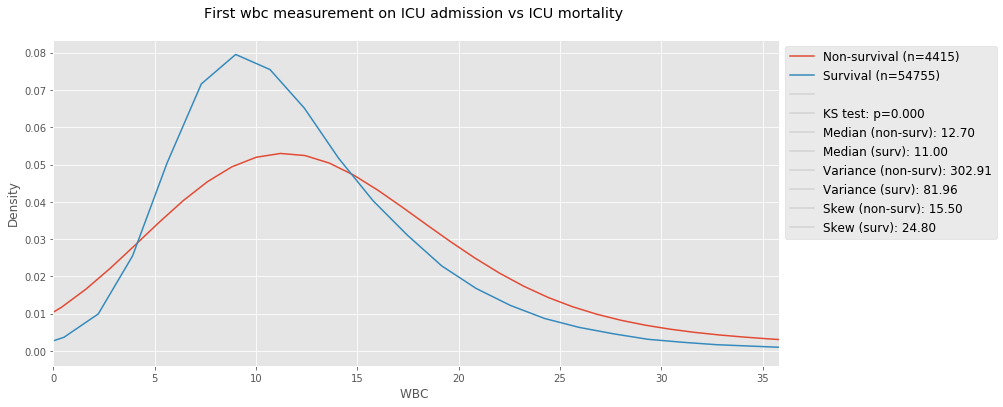

In [6]:
# Plot first laboratory measurement on ICU admission vs ICU mortality
# Would be clearer to plot CDF
# Additional variables to be added: magnesium, phosphate, calcium

labs = {'ANIONGAP': 'mEq/L',
        'ALBUMIN': 'g/dL',
        'BICARBONATE': 'mEq/L',
        'BILIRUBIN': 'mg/dL',
        'BUN': '',
        'CHLORIDE': 'mEq/L',
        'CREATININE': 'mg/dL',
        'GLUCOSE': 'mg/dL',
        'HEMATOCRIT': '%',
        'HEMOGLOBIN': 'g/dL',
        'INR': '',
        'LACTATE': 'mmol/L',
        'MAGNESIUM': 'mmol/L',
        'PHOSPHATE': 'mg/dL',
        'PLATELET': 'K/uL',
        'POTASSIUM': 'mEq/L',
        'PT': '',
        'PTT': 'sec',
        'SODIUM':'mmol/L',
        'WBC': ''}

for l, u in iter(sorted(labs.items())):
    # count patients
    n_nonsurv = data[l.lower()+'_1st'][data.mort_icu==1].dropna().count()
    n_surv = data[l.lower()+'_1st'][data.mort_icu==0].dropna().count()
    
    # get median, variance, skewness
    med_nonsurv = data[l.lower()+'_1st'][data.mort_icu==1].dropna().median()
    med_surv = data[l.lower()+'_1st'][data.mort_icu==0].dropna().median()
    var_nonsurv = data[l.lower()+'_1st'][data.mort_icu==1].dropna().var()
    var_surv = data[l.lower()+'_1st'][data.mort_icu==0].dropna().var()
    skew_nonsurv = data[l.lower()+'_1st'][data.mort_icu==1].dropna().skew()
    skew_surv = data[l.lower()+'_1st'][data.mort_icu==0].dropna().skew() 
    
    # Are the 2 samples drawn from the same continuous distribution? 
    # Try Kolmogorov Smirnov test 
    ks_stat, p_val = ks_2samp(data[l.lower()+'_1st'][data.mort_icu==1].dropna(),
                              data[l.lower()+'_1st'][data.mort_icu==0].dropna())

    # plot
    plt.subplots(figsize=(13,6))
    data[l.lower()+'_1st'][data.mort_icu==1].dropna().plot.kde(
        alpha=1.0,label='Non-survival (n={})'.format(n_nonsurv))
    data[l.lower()+'_1st'][data.mort_icu==0].dropna().plot.kde(
        alpha=1.0,label='Survival (n={})'.format(n_surv))
    
    # fake plots for KS test, median, etc
    plt.plot([], label=' ',color='lightgray')
    plt.plot([], label='KS test: p={}'.format(format(p_val,'.3f')),
             color='lightgray')
    plt.plot([], label='Median (non-surv): {}'.format(format(med_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Median (surv): {}'.format(format(med_surv,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (non-surv): {}'.format(format(var_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (surv): {}'.format(format(var_surv,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (non-surv): {}'.format(format(skew_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (surv): {}'.format(format(skew_surv,'.2f')),
             color='lightgray')

    # add title, labels etc.
    plt.title('First {} measurement on ICU admission '.format(l.lower()) +
               'vs ICU mortality \n')
    plt.xlabel(l + ' ' + u)
    plt.legend(loc="upper left", bbox_to_anchor=(1,1),fontsize=12)
    plt.xlim(0, data[l.lower()+'_1st'].quantile(0.99))
    
    # Add lab range if available
    if l in lab_ranges:
        plt.axvline(lab_ranges[l][0],color='k',linestyle='--')
        plt.axvline(lab_ranges[l][1],color='k',linestyle='--')
    

In [7]:
# Risk of patients with labs outside the normal range
data.loc[data['mort_icu']==0].head()

,subject_id,hadm_id,icustay_id,mort_icu,mort_hosp,aniongap_1st,albumin_1st,bicarbonate_1st,bilirubin_1st,creatinine_1st,...,magnesium_1st,phosphate_1st,platelet_1st,potassium_1st,ptt_1st,inr_1st,pt_1st,sodium_1st,bun_1st,wbc_1st
0,2,163353,243653,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,0.1
1,3,145834,211552,0,0,17.0,1.8,25.0,0.8,3.2,...,2.4,4.8,282.0,5.4,30.7,1.3,13.5,136.0,53.0,12.7
2,4,185777,294638,0,0,15.0,2.8,21.0,1.9,0.5,...,1.9,3.1,201.0,3.3,33.2,1.1,12.8,141.0,10.0,9.7
3,5,178980,214757,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,309.0,NaN,NaN,NaN,NaN,NaN,NaN,13.9
4,6,107064,228232,0,0,23.0,3.0,15.0,0.2,11.7,...,2.0,8.5,315.0,5.4,139.0,1.4,14.6,138.0,62.0,10.6
